In [ ]:
https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
https://machinelearningmastery.com/time-series-data-stationary-python/
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
    
    http://ucanalytics.com/blogs/step-by-step-graphic-guide-to-forecasting-through-arima-modeling-in-r-manufacturing-case-study-example/

https://www.kaggle.com/rtatman/us-candy-production-by-month
        

In [67]:
import pandas as pd

df = pd.read_csv('data/AirPassengers.csv', parse_dates=['Month'], index_col=0)

In [68]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [69]:
ts = df['#Passengers']

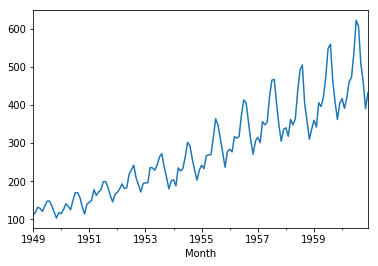

In [70]:
%matplotlib inline

ax = ts.plot()

In [73]:
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt

def plot_timeseries_mean_std(the_ts):
    _ = plt.plot(the_ts, color='blue',label='Original')
    _ = plt.plot(the_ts.rolling(window=12).mean(), color='red', label='Rolling Mean')
    _ = plt.plot(the_ts.rolling(window=12).std(), color='black', label='Rolling Std')
    _ = plt.legend(loc='best')
    _ = plt.title('Rolling Mean & Standard Deviation')
    
def do_timeseries_test(the_ts):
    res = adfuller(the_ts, autolag='AIC')

    print('ADF Statistic: {:.2f}'.format(res[0]))
    print('P-value:       {:.2f}'.format(res[1]))

    print('Critical Values:')
    for key, value in res[4].items():
        print('     {:>3s}:     {:.2f}'.format(key, value))

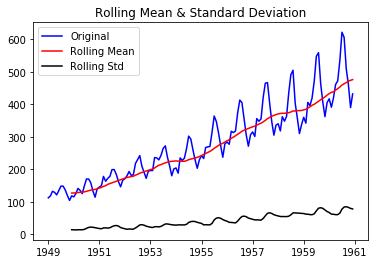

In [74]:
plot_timeseries_mean_std(ts)

In [75]:
do_timeseries_test(ts)

ADF Statistic: 0.82
P-value:       0.99
Critical Values:
      1%:     -3.48
      5%:     -2.88
     10%:     -2.58


In [77]:
import numpy as np

ts_log = np.log(ts)
ts_diff = (ts - ts.shift()).dropna()
ts_log_diff = (ts_log - ts_log.shift()).dropna()

In [78]:
do_timeseries_test(ts_log)

ADF Statistic: -1.72
P-value:       0.42
Critical Values:
      1%:     -3.48
      5%:     -2.88
     10%:     -2.58


In [79]:
do_timeseries_test(ts_diff)

ADF Statistic: -2.83
P-value:       0.05
Critical Values:
      1%:     -3.48
      5%:     -2.88
     10%:     -2.58


In [80]:
do_timeseries_test(ts_log_diff)

ADF Statistic: -2.72
P-value:       0.07
Critical Values:
      1%:     -3.48
      5%:     -2.88
     10%:     -2.58


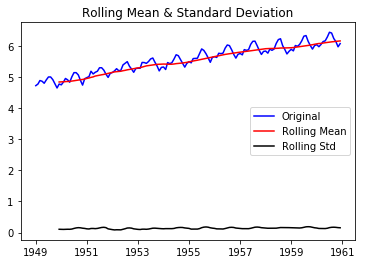

In [133]:
plot_timeseries_mean_std(ts_log)

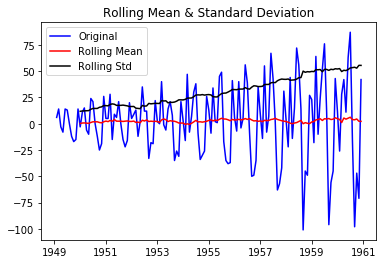

In [132]:
plot_timeseries_mean_std(ts_diff)

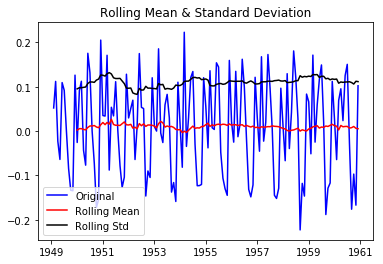

In [90]:
plot_timeseries_mean_std(ts_log_diff)

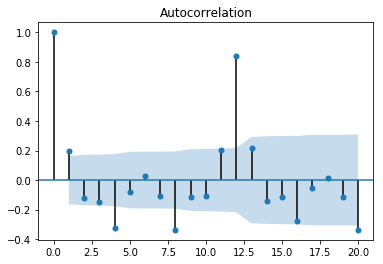

In [91]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ax = plot_acf(ts_log_diff, lags=20)

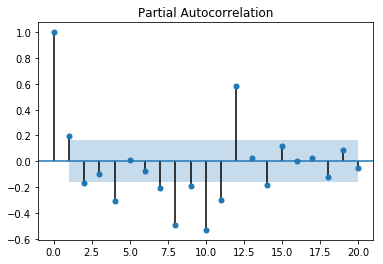

In [92]:
ax = plot_pacf(ts_log_diff, lags=20)

In [107]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log_diff, order=(12, 0, 0))  
results = model.fit()

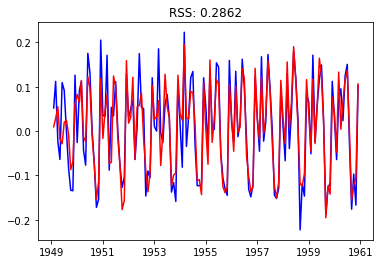

In [108]:
_ = plt.plot(ts_log_diff, color='blue')
_ = plt.plot(results.fittedvalues, color='red')
_ = plt.title('RSS: %.4f' % sum(((results.fittedvalues - ts_log_diff)**2).dropna()))

In [109]:
predictions_diff = pd.Series(results.fittedvalues, copy=True)
predictions_diff_cumsum = predictions_diff.cumsum()

predictions = pd.Series(ts_log.ix[0], index=df.index)
predictions = predictions.add(predictions_diff_cumsum, fill_value=0)

predictions = np.exp(predictions)

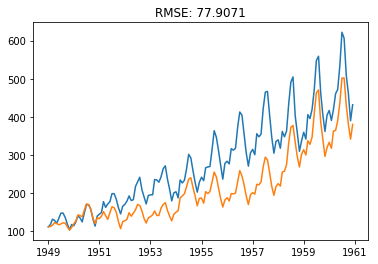

In [110]:
_ = plt.plot(ts)
_ = plt.plot(predictions)
_ = plt.title('RMSE: %.4f'% np.sqrt(sum((predictions-ts)**2)/len(ts)))

In [ ]:
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [111]:
import itertools

p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [150]:
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages

best_params = None
best_seasonal_params = None
best_aic = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_log_diff, order=param, seasonal_order=param_seasonal)

            results = mod.fit()
            
            if (not best_aic) or (results.aic < best_aic):
                best_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                print('NEW BEST ARIMA {}x{} - AIC:{}'.format(best_params, best_seasonal_params, best_aic))  

            #print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            #print('...')
        except:
            continue

NEW BEST ARIMA (0, 0, 0)x(0, 0, 1, 12) - AIC:-333.09087901154385
NEW BEST ARIMA (0, 0, 0)x(0, 1, 1, 12) - AIC:-467.55271887449135
NEW BEST ARIMA (0, 0, 0)x(1, 0, 1, 12) - AIC:-486.99526082501967
NEW BEST ARIMA (0, 0, 1)x(1, 0, 1, 12) - AIC:-499.31612618526873


In [160]:
mod = sm.tsa.statespace.SARIMAX(ts_log_diff, order=(1, 0, 0), seasonal_order=(1, 0, 1, 12))

results = mod.fit()

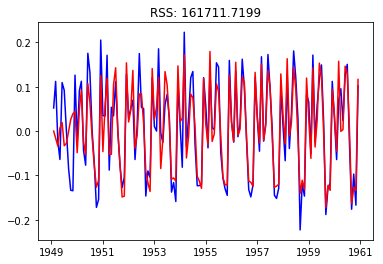

In [161]:
_ = plt.plot(ts_log_diff, color='blue')
_ = plt.plot(results.fittedvalues, color='red')
_ = plt.title('RSS: %.4f' % sum(((results.fittedvalues - ts_diff)**2).dropna()))

In [162]:
predictions_diff = pd.Series(results.fittedvalues, copy=True)
predictions_diff_cumsum = predictions_diff.cumsum()

predictions = pd.Series(ts_log.ix[0], index=df.index)
predictions = predictions.add(predictions_diff_cumsum, fill_value=0)

predictions = np.exp(predictions)

In [144]:
predictions = np.exp(results.fittedvalues)

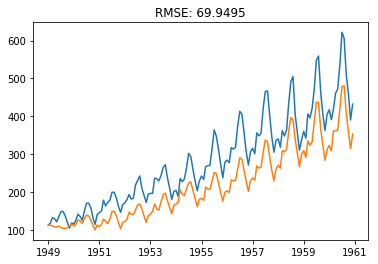

In [164]:
_ = plt.plot(ts)
_ = plt.plot(predictions)
_ = plt.title('RMSE: %.4f'% np.sqrt(sum((predictions-ts)**2)/len(ts)))

In [165]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3013      0.068     -4.424      0.000      -0.435      -0.168
ar.S.L12       0.9897      0.008    122.144      0.000       0.974       1.006
ma.S.L12      -0.5592      0.098     -5.698      0.000      -0.752      -0.367
sigma2         0.0014      0.000      8.725      0.000       0.001       0.002


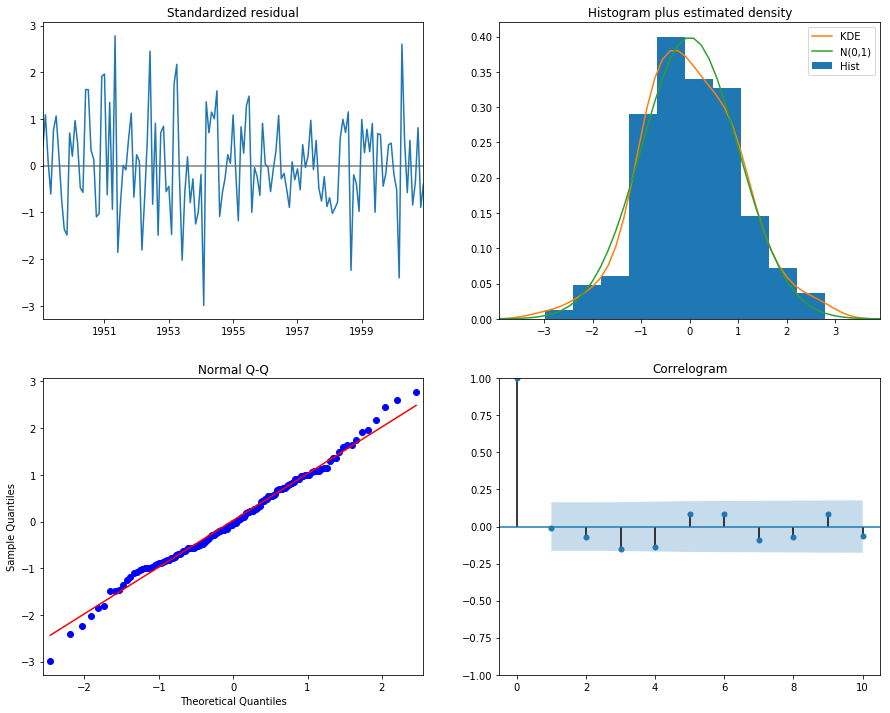

In [166]:
_ = results.plot_diagnostics(figsize=(15, 12))